In [ ]:
# Clone the repositories
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!git clone https://github.com/salesforce/BLIP
# Install the requirements
!pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 ninja==1.11.1.1
!pip install ftfy==6.1.3 regex==2023.12.25 tqdm==4.66.2
!pip install transformers==4.19.4 timm==0.9.16 fairscale==0.4.13
# Download the pre-trained models
!mkdir pretrained_models
!gdown -O test.png https://drive.google.com/uc?id=1hfVAbs5nkXcUpG6FCAafid7F7ZsqRRkk
!curl -L --output pretrained_models/stylegan2-ffhq-512x512.pkl 'https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true&path=stylegan2-ffhq-512x512.pkl'
!curl -L --output pretrained_models/ViT-B-32.pt 'https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt'
!curl -L --output pretrained_models/model_base_capfilt_large.pth https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (98/98), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 251, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 251 (delta 3), reused 2 (delta 0), pack-reused 243
Receiving objects: 100% (251/251), 8.93 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (127/127), done.
Cloning into 'BLIP'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 277 (delta 137), reused 136 (delta 135), pack-reused 112
Receiving objects: 100% (277/277), 7.03 MiB | 13.62 MiB/s, done.
Resolving deltas: 100% (152/152), done.
     ━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import pickle
import sys
import CLIP.clip.clip as clip
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import os
import PIL
sys.path.append('BLIP') # a folder BLIP is in the same directory as this notebook
from BLIP.models.blip import blip_decoder # to use class in: pwd/BLIP/models/blip.py

# Network
class TextToLatentEncoder(nn.Module):
    def __init__(self, input_dim=512, output_dim=8192):
        super(TextToLatentEncoder, self).__init__()
        # Initialize network layers
        self.relu = nn.LeakyReLU(0.2)
        self.fc1 = nn.Linear(input_dim, 1024)
        self.dropout1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(1024, 2048)
        self.dropout2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(2048, 4096)
        self.dropout3 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(4096, 8192)  # Expanded to directly go to 8192 if needed
        self.dropout4 = nn.Dropout(0.25)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout4(x)

        return x


In [ ]:
# L2
def loss_calc_l2(text_emb, z):
  return torch.norm(text_emb - z)

# L1
def loss_calc_l1(text_emb, z):
  return torch.sum(torch.abs(text_emb - z))


In [ ]:
from tqdm.auto import tqdm
sys.path.append('stylegan3')  # assuming stylegan3 is in the same directory as this notebook

# Load the StyleGAN model
device = "cuda" if torch.cuda.is_available() else "cpu"
with open('pretrained_models/stylegan2-ffhq-512x512.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # Load pretrained StyleGAN model
    G.eval()

# Load the CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# BLIP
blip_model_url = 'pretrained_models/model_base_capfilt_large.pth'
med_config_path = os.getcwd() + '/BLIP/configs/med_config.json'
blip_model = blip_decoder(pretrained=blip_model_url, image_size=512, vit='base', med_config = med_config_path)
blip_model = blip_model.to(device)

encoder = TextToLatentEncoder(input_dim=512, output_dim=G.z_dim).to(device)
encoder.float()  # Ensure the encoder uses Float dtype
optimizer = optim.Adam(encoder.parameters(), lr=0.0005)

encoder = encoder.float()
G = G.float()
clip_model = clip_model.float()
encoder.train()
G.eval()

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 117MiB/s]


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

reshape position embedding from 196 to 1024
load checkpoint from pretrained_models/model_base_capfilt_large.pth


Generator(
  (synthesis): SynthesisNetwork(
    w_dim=512, num_ws=16, img_resolution=512, img_channels=3, num_fp16_res=4
    (b4): SynthesisBlock(
      resolution=4, architecture=skip
      (conv1): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=4, up=1, activation=lrelu
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
      (torgb): ToRGBLayer(
        in_channels=512, out_channels=3, w_dim=512
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
    )
    (b8): SynthesisBlock(
      resolution=8, architecture=skip
      (conv0): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=8, up=2, activation=lrelu
        (affine): FullyConnectedLayer(in_features=512, out_features=512, activation=linear)
      )
      (conv1): SynthesisLayer(
        in_channels=512, out_channels=512, w_dim=512, resolution=8, up=1, activation=lrelu
 

In [ ]:
nb_iter = 2000
losses = []

for idx in tqdm(range(nb_iter)):
  z = torch.randn([1, G.z_dim]).to(device)
  w = G.mapping(z, None) # styleGAN output - w: 1, 16, 512
  generated_image = G.synthesis.forward(w)
  generated_image = (generated_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  width, h = generated_image.size()[1], generated_image.size()[2]

  transform = transforms.Compose([
      transforms.Resize((width,h),interpolation=InterpolationMode.BICUBIC),
      transforms.ToTensor(),
      transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
      ])

  generated_image = PIL.Image.fromarray(generated_image[0].cpu().numpy(), 'RGB').resize((224, 224))
  image = transform(generated_image).unsqueeze(0).to(device)

  with torch.no_grad():
      caption = blip_model.generate(image, sample=False, num_beams=3, max_length=20, min_length=10)
      print('caption: '+caption[0])
  blipout = caption[0] # BLIP's output (description of a StyleGAN-generated image)

# CLIP
  text = clip.tokenize([blipout]).to(device)

  with torch.no_grad():
      text_features = clip_model.encode_text(text)

  print("Text features (tensor size): ",len(text_features[0]))

  #z = torch.randn([1, G.z_dim]).cpu()  # random latent codes
  clipout = text_features
  print("clipout", clipout.shape)
  clipout = clipout.view(1, 1, 512)

  optimizer.zero_grad()
  a = encoder(clipout)
  loss = loss_calc_l2(w, torch.reshape(a, (1,16,512)))
  print(loss)
  loss.backward()
  optimizer.step()

  losses.append(loss.item())
  print(f"Iter {idx+1}, Loss: {loss.item()}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
caption: a man smiling for the camera
Text features (tensor size):  512
clipout torch.Size([1, 512])
tensor(48.6125, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Iter 1001, Loss: 48.61249542236328
caption: a woman wearing a headdre
Text features (tensor size):  512
clipout torch.Size([1, 512])
tensor(61.5464, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Iter 1002, Loss: 61.54636764526367
caption: a woman and a man kissing
Text features (tensor size):  512
clipout torch.Size([1, 512])
tensor(48.5039, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Iter 1003, Loss: 48.503902435302734
caption: a woman smiling and holding a cell
Text features (tensor size):  512
clipout torch.Size([1, 512])
tensor(66.6165, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
Iter 1004, Loss: 66.61646270751953
caption: a man in a graduation cap
Text features (tensor size):  512
clipout torch.Size([1, 512])
tensor(55.2922, device='cu

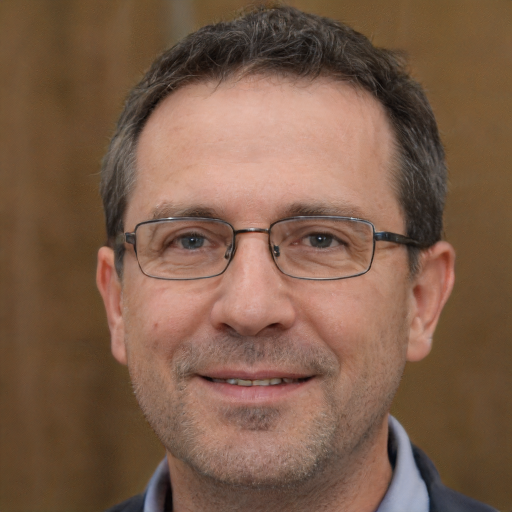

In [ ]:
encoder.eval()
G.eval()

# Tokenize and encode the text description using CLIP
tokens = clip.tokenize(["a man with glasses"]).to(device)
text_embedding = clip_model.encode_text(tokens).float()

with torch.no_grad():
    latent_vector = encoder(text_embedding)

# Generate an image using the predicted latent vector with StyleGAN
generated_image = G.synthesis(torch.reshape(latent_vector, (1,16,512)))
generated_image = (generated_image.clamp(-1, 1) + 1) / 2  # Normalize to [0, 1]
generated_image = generated_image.cpu().permute(0, 2, 3, 1).numpy()  # Adjust dimensions for image display
generated_image = (generated_image * 255).astype('uint8')  # Convert to uint

# Convert to PIL Image for display
generated_image = Image.fromarray(generated_image[0])
generated_image